In [1]:
import os
import anndata
import scanpy as sc
import numpy as np
import pandas as pd

from matplotlib.pyplot import rc_context

In [2]:
def read_bulk_RNAs(_path, cell_type):
    results = pd.DataFrame()
    for _, _, files in os.walk(_path, topdown=False):
        for file in files:
            if file.split('.')[-1] != 'tsv':
                continue
            df = pd.read_table(os.path.join(_path, file), index_col='gene_id', usecols=['gene_id', 'expected_count'])
            df = df.astype(np.float32).T
            df.index = [file.split('.')[0]]
            print('{} {}'.format(file, df.shape))
            results = pd.concat([results, df])
    results = sc.AnnData(results)
    results.obs['cell_type'] = cell_type
    return results

# ENCODE4 v1.2.1 GRCh38 V29
bulk_RNAs = anndata.concat([
    read_bulk_RNAs('/lmh_data/data/sclab/bulk_data/{}'.format(cell_type), cell_type)
    for cell_type in ['GM12878', 'K562', 'IMR90', 'Endo']])
bulk_RNAs

ENCFF345SHY.tsv (1, 59526)
ENCFF084FUG.tsv (1, 59526)
ENCFF240WBI.tsv (1, 59526)
ENCFF362RMV.tsv (1, 59526)
ENCFF928NYA.tsv (1, 59526)
ENCFF421TJX.tsv (1, 59526)
ENCFF842TMB.tsv (1, 59526)
ENCFF325KTI.tsv (1, 59526)
ENCFF014JRQ.tsv (1, 59526)
ENCFF892OHT.tsv (1, 59526)


AnnData object with n_obs × n_vars = 10 × 59526
    obs: 'cell_type'

In [3]:
v19_anno = pd.read_csv('/lmh_data/data/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno = v19_anno[v19_anno['type']=='gene']
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\S*)(")')[1]
# v19_anno['gene_id'] = v19_anno['info'].str.extract(r'(gene_id ")(\S*)(\.)')[1]
v19_anno['gene_id'] = v19_anno['info'].str.extract(r'(gene_id ")(\S*)(")')[1]
v19_anno

,chrom,type,start,end,strand,info,gene_name,gene_id
0,chr1,gene,11869,14412,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,ENSG00000223972.4
21,chr1,gene,14363,29806,-,"gene_id ""ENSG00000227232.4""; transcript_id ""EN...",WASH7P,ENSG00000227232.4
82,chr1,gene,29554,31109,+,"gene_id ""ENSG00000243485.2""; transcript_id ""EN...",MIR1302-11,ENSG00000243485.2
92,chr1,gene,34554,36081,-,"gene_id ""ENSG00000237613.2""; transcript_id ""EN...",FAM138A,ENSG00000237613.2
100,chr1,gene,52473,54936,+,"gene_id ""ENSG00000268020.2""; transcript_id ""EN...",OR4G4P,ENSG00000268020.2
...,...,...,...,...,...,...,...,...
2619425,chrM,gene,14149,14673,-,"gene_id ""ENSG00000198695.2""; transcript_id ""EN...",MT-ND6,ENSG00000198695.2
2619430,chrM,gene,14674,14742,-,"gene_id ""ENSG00000210194.1""; transcript_id ""EN...",MT-TE,ENSG00000210194.1
2619433,chrM,gene,14747,15887,+,"gene_id ""ENSG00000198727.2""; transcript_id ""EN...",MT-CYB,ENSG00000198727.2
2619438,chrM,gene,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,ENSG00000210195.2


In [4]:
_map_gene_names = set(bulk_RNAs.var_names) & set(v19_anno['gene_id'].unique())
bulk_RNAs = bulk_RNAs[:, bulk_RNAs.var[bulk_RNAs.var_names.isin(_map_gene_names)].index]

bulk_RNAs.var_names

Index(['ENSG00000000005.5', 'ENSG00000001561.6', 'ENSG00000004799.7',
       'ENSG00000005022.5', 'ENSG00000005073.5', 'ENSG00000005513.9',
       'ENSG00000006059.3', 'ENSG00000006116.3', 'ENSG00000006210.6',
       'ENSG00000006831.9',
       ...
       'ENSG00000273474.1', 'ENSG00000273476.1', 'ENSG00000273481.1',
       'ENSG00000273483.1', 'ENSG00000273484.1', 'ENSG00000273485.1',
       'ENSG00000273486.1', 'ENSG00000273487.1', 'ENSG00000273489.1',
       'ENSG00000273493.1'],
      dtype='object', name='gene_id', length=29842)

In [5]:
bulk_RNAs.var_names = [v19_anno[v19_anno['gene_id']==_name]['gene_name'].values[0] for _name in bulk_RNAs.var_names]
bulk_RNAs.var_names

Index(['TNMD', 'ENPP4', 'PDK4', 'SLC25A5', 'HOXA11', 'SOX8', 'KRT33A',
       'CACNG3', 'CX3CL1', 'ADIPOR2',
       ...
       'RP11-295P9.12', 'RP11-108L7.14', 'RP11-126K1.9', 'RP4-671G15.2',
       'OR6R2P', 'RP11-225H22.7', 'RP11-731C17.2', 'RP4-621B10.8',
       'RP11-180C16.1', 'RP11-80H18.4'],
      dtype='object', length=29842)

In [6]:
bulk_RNAs = bulk_RNAs[:, ~bulk_RNAs.var.index.duplicated()]
bulk_RNAs

View of AnnData object with n_obs × n_vars = 10 × 28660
    obs: 'cell_type'

In [7]:
train_set = np.load('/lmh_data/data/sclab/sclab/train_dataset.npy', allow_pickle=True)
scRNA_head = train_set[0]['scRNA_head']
scRNA_head

Index(['DDX11L1', 'WASH7P', 'MIR1302-2', 'FAM138A', 'OR4G4P', 'OR4G11P',
       'OR4F5', 'CICP27', 'OR4F29', 'CICP7',
       ...
       'RBMY2DP', 'PPP1R12BP1', 'CYCSP48', 'ANKRD36P1', 'CYCSP49', 'TPTE2P4',
       'SLC25A15P1', 'PARP4P1', 'FAM58CP', 'CTBP2P1'],
      dtype='object', length=29175)

In [8]:
gene_names = set(scRNA_head) & set(bulk_RNAs.var_names)
len(gene_names)

10072

In [9]:
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna = rna[rna.obs['cell_type'].isin(['Astro', 'Endo', 'ODC', 'OPC']),:]
rna

View of AnnData object with n_obs × n_vars = 3857 × 50281
    obs: 'cell_type', 'domain'

In [10]:
_rna = rna[:, list(gene_names)].copy()
_adata = bulk_RNAs[:, list(gene_names)].copy()

_rna.obs.loc[:, 'category'] = 'single_cell'
_adata.obs.loc[:, 'category'] = 'bulk'
_adata.obs.loc[:, 'transfer_label'] = _adata.obs.cell_type

In [11]:
import scanorama
_combine = scanorama.correct_scanpy([_rna, _adata], return_dimred=True)
_combine

Found 10072 genes among all datasets
[[0. 1.]
 [0. 0.]]
Processing datasets (0, 1)


/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanorama/scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


[AnnData object with n_obs × n_vars = 3857 × 10072
     obs: 'cell_type', 'domain', 'category'
     obsm: 'X_scanorama',
 AnnData object with n_obs × n_vars = 10 × 10072
     obs: 'cell_type', 'category', 'transfer_label'
     obsm: 'X_scanorama']

In [12]:
_test = anndata.concat(_combine)
sc.pp.neighbors(_test, metric = "cosine", use_rep = "X_scanorama")

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

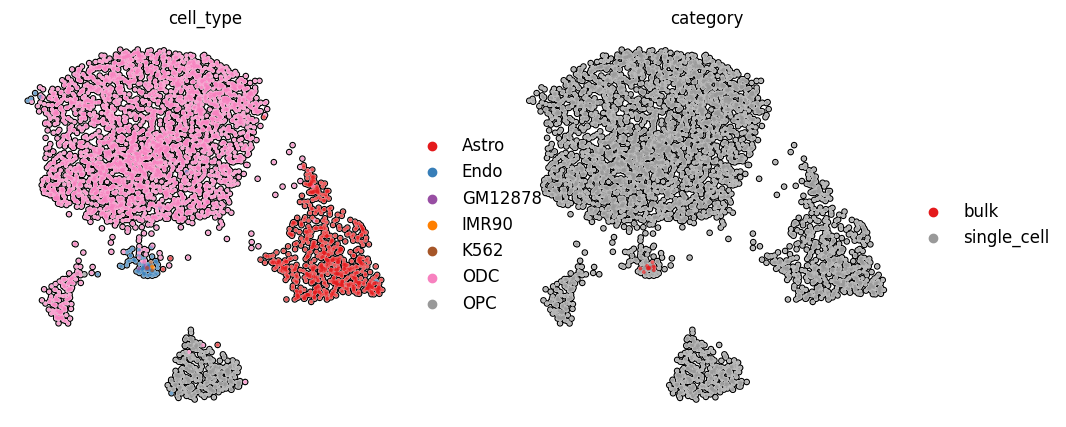

In [13]:
sc.tl.umap(_test)
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(_test, color=['cell_type', 'category'], add_outline=True,
#                legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

In [14]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    _combine[1].obsm["X_scanorama"],
    _combine[0].obsm["X_scanorama"],
)

def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

class_prob = label_transfer(distances, _combine[1].obs.transfer_label)
cp_df = pd.DataFrame(class_prob, columns=np.sort(_combine[1].obs.transfer_label.unique()))
cp_df.index = _combine[0].obs.index
cp_df

,Endo,GM12878,IMR90,K562
sample_name,,,,
AAACCCACAGTGAGCA-LKTX_190129_01_A01,0.393760,0.122901,0.338974,0.213571
AAAGGTATCGGCTGGT-LKTX_190129_01_A01,0.428154,0.126424,0.323212,0.210492
AAGAACACAACACGAG-LKTX_190129_01_A01,0.578249,0.910993,0.762614,0.682772
AAGACTCAGGGAACAA-LKTX_190129_01_A01,0.571861,0.841857,0.761633,0.804570
AATCACGAGAGTCCGA-LKTX_190129_01_A01,0.415524,0.088548,0.350211,0.251984
...,...,...,...,...
TTTGACTAGCACCGAA-LKTX_190130_01_H01,0.378344,0.075881,0.355993,0.285234
TTTGATCGTGGAACAC-LKTX_190130_01_H01,0.413905,0.121791,0.331512,0.214318
TTTGGTTGTAATTAGG-LKTX_190130_01_H01,0.377705,0.139924,0.342102,0.194957


In [15]:
GM12878 = cp_df.sort_values('GM12878', ascending=False, inplace=False)[:30].index
IMR90 = cp_df.sort_values('IMR90', ascending=False, inplace=False)[:30].index
K562 = cp_df.sort_values('K562', ascending=False, inplace=False)[:30].index
Endo = cp_df.sort_values('Endo', ascending=False, inplace=False)[:30].index

# GM12878 = _combine[0][cp_df[cp_df['GM12878']>cp_df['IMR90']+cp_df['K562']].index, :].obs_names
# IMR90 = _combine[0][cp_df[cp_df['IMR90']>cp_df['GM12878']+cp_df['K562']].index, :].obs_names
# K562 = _combine[0][cp_df[cp_df['K562']>cp_df['IMR90']+cp_df['GM12878']].index, :].obs_names

In [16]:
train_rna = anndata.read_h5ad("/lmh_data/data/sclab/sclab/rna_result.h5ad")

_dataset = []
def get_dataset(_indexs, transfer_label):
    for _index in _indexs:
        _case = rna[_index, train_rna.var_names]
        _dataset.append({
            'scRNA': _case.X.toarray()[0].astype(np.int32),
            'scRNA_head': _case.var_names,
            'cell_type': _case.obs['cell_type'].values[0],
            'transfer_label': transfer_label,
        })

get_dataset(GM12878, 'GM12878')
get_dataset(IMR90, 'IMR90')
get_dataset(K562, 'K562')
get_dataset(Endo, 'Endo')
np.save('/lmh_data/data/sclab/sclab/bulk/eval_dataset.npy', _dataset)

In [34]:
_t = _test.copy()
_t.obs.cell_type = _t.obs.cell_type.astype(str)
_index = _t.obs[(_t.obs['category']=='bulk')&(_t.obs['cell_type']=='Endo')].index
_t.obs.loc[_index, 'cell_type'] = 'Endo(bulk)'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

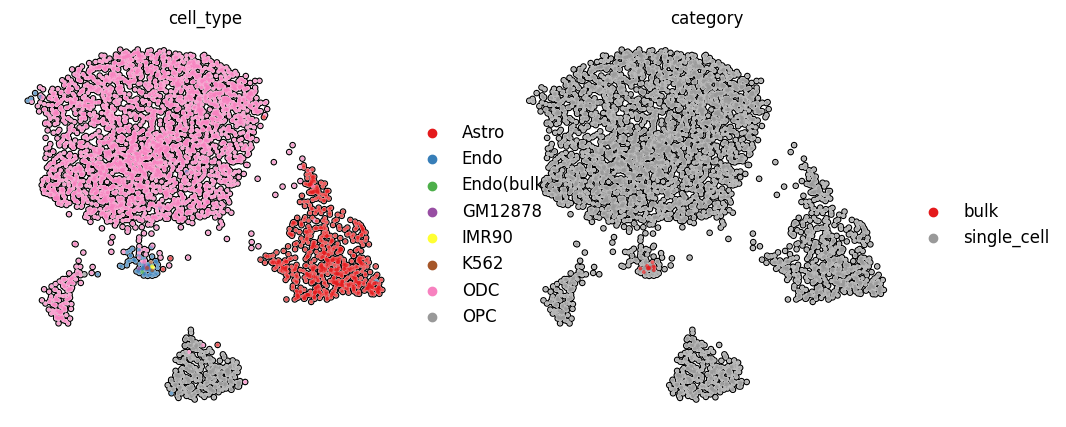

In [36]:
import matplotlib.pyplot as plt

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(_t, color=['cell_type', 'category'], add_outline=True,
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1', return_fig=True)
    plt.savefig('/lmh_data/work/SEE/analyse/figure_file/bulk_map.pdf', format='pdf', bbox_inches='tight')
    plt.show()